In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.colors as colors
import numpy as np



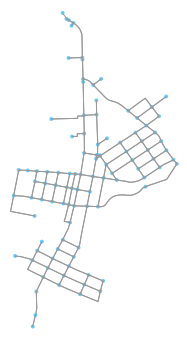

(<Figure size 223.189x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8aeffc5b38>)

In [2]:
town = ox.graph_from_place('Wind Gap, Pennsylvania, USA', network_type='drive')
ox.plot_graph(ox.project_graph(town))
# here is the intial town

In [8]:
# we want more than the town though, because we care about cutting it off from the outside, so we need to know about 
# the outside. For now, let's get everything within 10km of the center of town

G = None
town_nodes = ox.graph_to_gdfs(town, edges=False)
town_nodes['in_town'] = 1
                              
# create gdf of the graph edges
gdf_edges = ox.graph_to_gdfs(town, nodes=False, fill_edge_geometry=True)
# get graph centroid
x, y = gdf_edges.unary_union.centroid.xy
graph_centroid = (y[0], x[0])
G = ox.graph_from_point(graph_centroid, distance=3000,  network_type='drive')

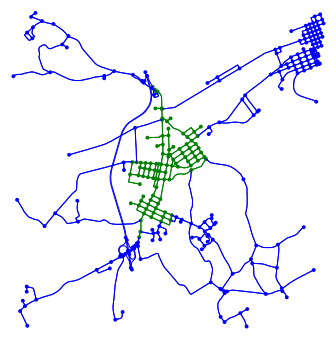

(<Figure size 564.694x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8aedb59780>)

In [9]:
nc = ['g' if node in town else 'b' for node in G.nodes()]
ec = ['g' if e in town.edges() else 'b' for e in G.edges()]
ox.plot_graph(G, node_color=nc, edge_color=ec)
# green is the town


In [20]:
# so now that we have the graph, let's see how to cut it off
# Task 1: isolate the town!
# psudo code:
# for every node in the town
    # if it has an edge to something outside the town:
        # color that edge red!

# we're working with dataframes though, so we're not gonna use loops here and leverage the data structure instead
nodes, edges = ox.graph_to_gdfs(G)

tn = set(town_nodes['osmid'])
us = set(list(edges['u']))
print(edges.shape)
block = edges[edges["u"].isin(tn)]


(840, 13)
(840, 13)
(309, 13)
